In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import daft
import pystan
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

We want to see if we can (in a principled way, of course) stack "tests of GR" expressed as factors modifying a particular pN coefficient to extract information about or bound possible deviations.

In the absence of a model for how the deviations should behave as a function of the parameters of each system, a natural test is to look simultaneously for both

 * A shared "offset" such that the devaition parameter does not center around zero for the ensemble of systems
 * A measurable dispersion in the deviation parameter (with or without an offset) that suggests it is not identically zero for each system.
 
We can conduct such a search by fitting a hierarchical model (sometimes called a "population model," a "multi-level model," or an "extreme deconvolution") to the deviation parameters.  The simplest such model imposes a Gaussian population model with mean $\mu$ and s.d. $\sigma$; then the parameter $\mu$ fits the population mean deviation and $\sigma$ fits the population dispersion.  In GR, $\mu = \sigma = 0$; any measurably non-zero value indicates some deviation from GR in the population.

The model here is very similar to the classic "[eight schools](https://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/)" problem, but here we do not assume that the sampling distribution for the measurements (i.e. the likelihood function) is Gaussian, instead treating it as a KDE over samples drawn for each observation.

For more on hierarchical/multi-level modelling (aka "extreme deconvolution") see any good stats textbook or [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract), [Bovy, Hogg & Roweis (2010)](http://inspirehep.net/record/921489), or [Hogg, Myers & Bovy (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...725.2166H/abstract).

Assuming we have $i = 1, \ldots, N$ systems each with (GR) parameters $\theta_i$ and measured data $d_i$ and $\chi_i$ is the deviation parameter for each system (with $\chi_i = 0$ the GR prediciton), the graphical model we have is:

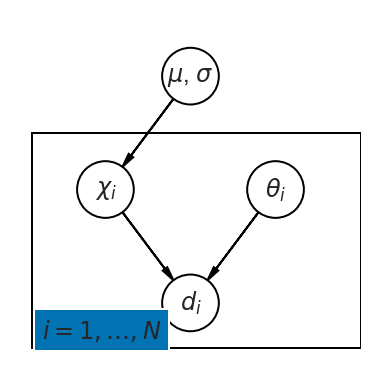

In [3]:
m = daft.PGM((3, 3))

m.add_node(daft.Node('mu-sigma', r'$\mu$, $\sigma$', 1.5, 2.5))
m.add_node(daft.Node('chi_i', r'$\chi_i$', 0.75, 1.5))
m.add_node(daft.Node('theta_i', r'$\theta_i$', 2.25, 1.5))
m.add_node(daft.Node('d_i', r'$d_i$', 1.5, 0.5))

m.add_plate(daft.Plate([0.1, 0.1, 2.9, 1.9], label=r'$i = 1,\ldots,N$'))

m.add_edge('mu-sigma', 'chi_i')
m.add_edge('theta_i', 'd_i')
m.add_edge('chi_i', 'd_i')

m.render()

Choosing to use marginalized samples for $\chi_i$ alone is equivalent to integrating out the GR parameters according to the prior; to the extent that the prior does not match the true population, one may expect to eventually see "artificial" deviations from GR that correct the mis-match between population and prior.  This can be ameloriated by either (a) incorporating the tests of GR into a full population analysis that simultaneously fits the population for $\theta$ with enough degrees of freedom to match sufficiently well the true population to eliminate this bias or (b) replacing the default prior with one from a pure-GR population analysis.  (b) is easier, but has the defect that the correlations (if any) between the population and the modified GR parameters are not explored.

It is straightforward to just re-weight the posterior samples over $\chi_i$ by the ratio of the Gaussian with $\mu$-$\sigma$ to the prior used in the original analysis

The below Stan code implements this model.  Given posterior samples over $\chi_i$ for $N$ events, assumed to be drawn from a flat prior on $\chi_i$ (so their density is proportional to the likelihood), it samples from the posterior in $\mu$ and $\sigma$.  There is really no good reason to sample over a 2D posterior, except that it's quick and easy to write the Stan model and harder to write a debugged gridded posterior evaluation:

In [4]:
model = pystan.StanModel(file='hierGRtest.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1e493280cc118c7779bdb630e44345d NOW.
/Users/maxisi/custompy3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/0x/37jrlqfs6sv4sr6n5bfc_p540000gq/T/tmpg06qnmyg/stanfit4anon_model_b1e493280cc118c7779bdb630e44345d_3331143876844229939.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Just to make sure we're on the right track, we test the model below.  We suppose that the true $\mu \sim 0.1$, $\sigma \sim 0.1$ while the measurement uncertainty on $\chi$ is $\sigma_\chi \sim 1$.  Since the population is 10 times narrower than the measurements, we should expect to see good population constraints around 100 observations.

First, we draw true $\chi$ values, scatter them by an observational error, and then draw posterior samples from a flat prior:

In [5]:
mu_true = -0.1
sigma_true = 0.1

sigma_chi = 1.0

Nchi_total = 1000
Npost = 4096

chi_trues = mu_true + sigma_true*randn(Nchi_total)
chi_obs = chi_trues + sigma_chi*randn(Nchi_total)

chi_samples = chi_obs[:,newaxis] + sigma_chi*randn(Nchi_total, Npost)

Text(0, 0.5, '$p\\left( d \\mid \\chi \\right)$')

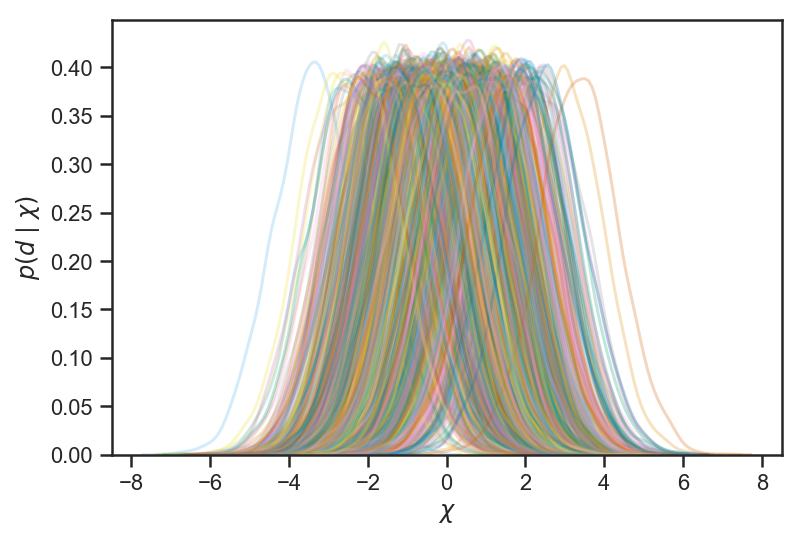

In [6]:
for i in range(Nchi_total):
    sns.kdeplot(chi_samples[i,:], alpha=0.25)
xlabel(r'$\chi$')
ylabel(r'$p\left( d \mid \chi \right)$')

First, a fit with 10 observations (I checked that the fit is converged as the number of samples increases):

In [7]:
def fit_it(chi_samples, nobs, nsamp):
    return model.sampling(data={'nobs': nobs, 'nsamp': nsamp, 'chis': chi_samples[:no, :ns]})

In [8]:
no = 10
ns = 16
fit10 = fit_it(chi_samples, no, ns)

With only 10 events, it is not clear whether either $\mu$ or $\sigma$ are bounded away from zero:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3236ab7b8>,
      dtype=object)

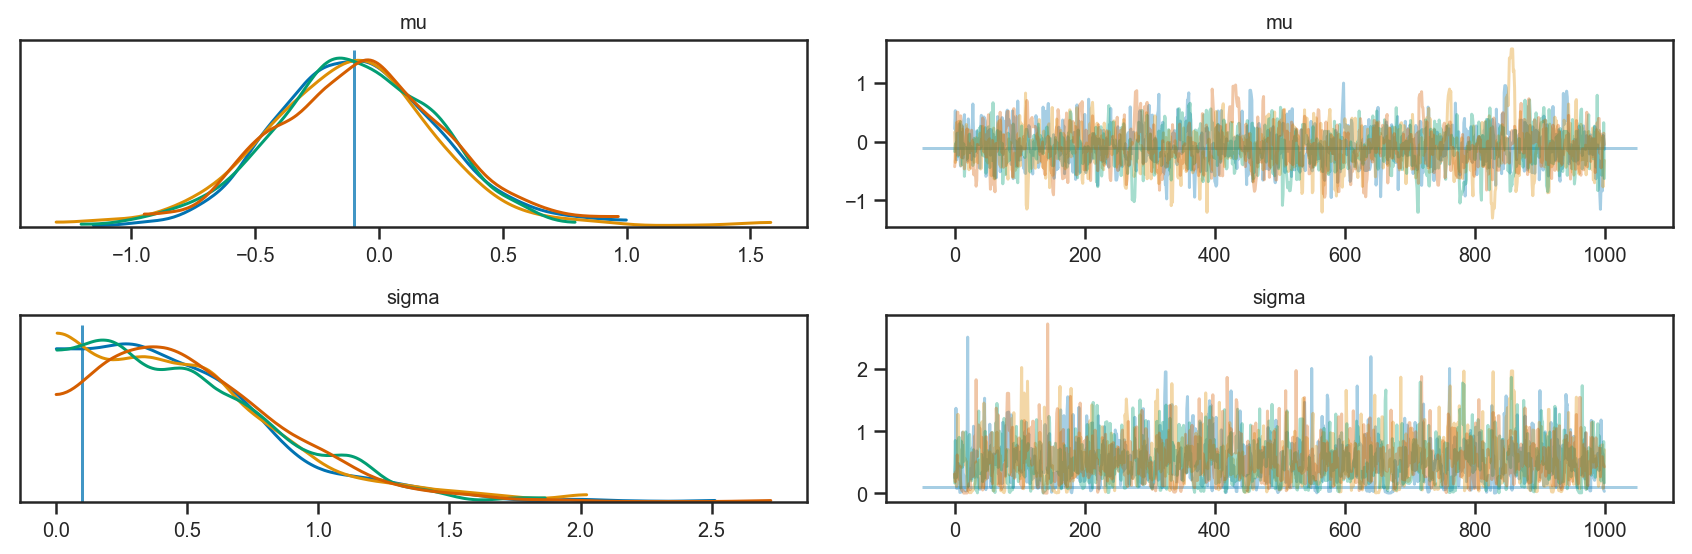

In [9]:
truth_lines = [('mu', {}, mu_true), ('sigma', {}, sigma_true)]
az.plot_trace(fit10, lines=truth_lines)

Then a fit with 100 observations:

In [21]:
no = 100
ns = 512
fit100 = fit_it(chi_samples, no, ns)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


With 100 events, we are starting to see that $\mu$ looks bounded away from zero, but have no good constraint on $\sigma$ yet.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3203a588>,
      dtype=object)

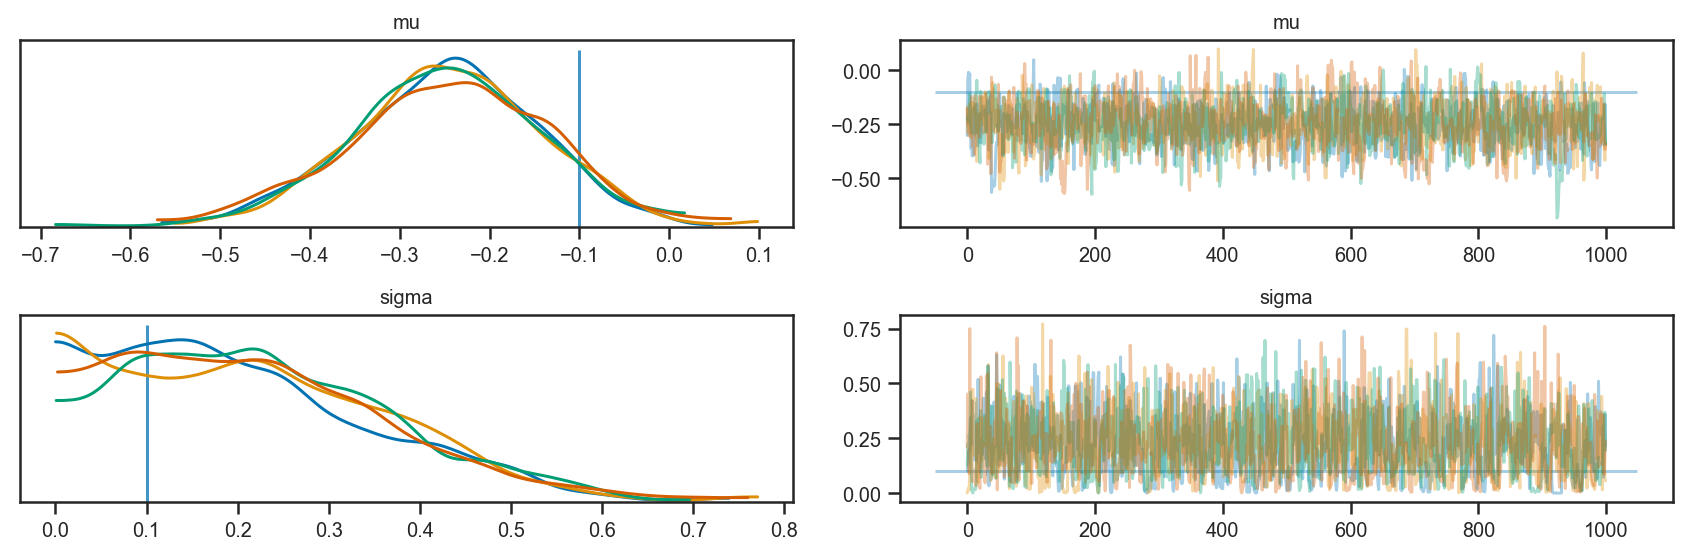

In [22]:
az.plot_trace(fit100, lines=truth_lines)

Then with 1000 observations

In [23]:
no = 1000
ns = 512
fit1000 = fit_it(chi_samples, no, ns)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


With 1000 events, we can very clearly see $\mu < 0$, and *may* be starting to see a peak in $\sigma$ around 0.1 (but still cannot really measure $\sigma$ very well, other than to constrain it to $< 0.3$:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c31a57908>,
      dtype=object)

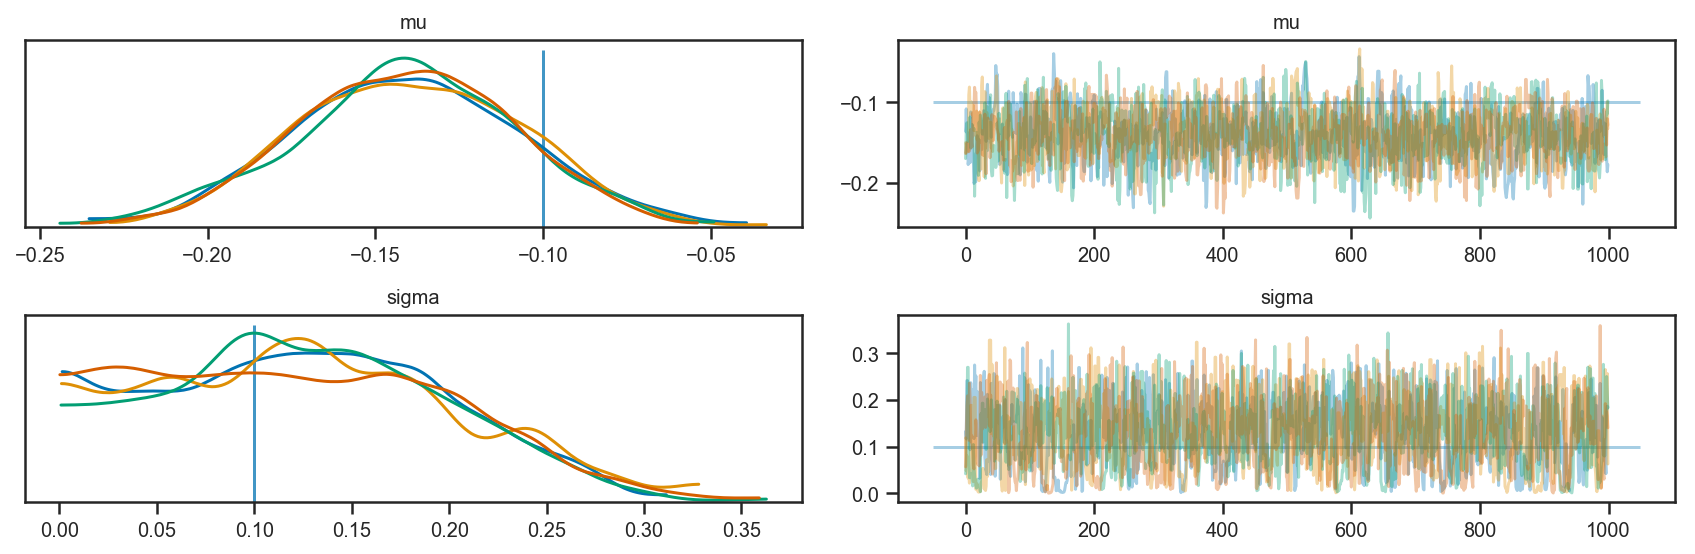

In [24]:
az.plot_trace(fit1000, lines=truth_lines)